# Researchplan on this file:
IDEA: Check if lying or true telling starts in different layers.  
Expectation: Through compexity Lying should starz in early layers before the true anser should appear and then it should flip to the wrong answer.   
Base Idea: Use Logit Lens to see how tokens envolve through the lyers.  
Experiment: NNsight to create logit lens.  
Experiment: Based on the paper Eliciting Latent Predictions from Transformers with Tuned Lens. We could use Tuned Lens to clean the output of the model. It is unclear at the moment for me why both cases are similar.   

It could be that Prompt crafting has to be done, or that it has to be focused on different token position.  

In [10]:
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
import re
import torch
from torch.utils.data import DataLoader
import gc
from datasets import load_dataset

In [2]:
import sys
import os

# Add the parent directory (sfc_deception) to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))

import utils.prompts as prompts


# Parameters


In [3]:
dataset_name = "drsis/deception-commonsense_qa"
model_name = "google/gemma-2-9b-it"


# Load Dataset

In [4]:
ds = load_dataset(dataset_name)

In [5]:
ds['train'][0]

{'id': '61fe6e879ff18686d7552425a36344c8',
 'question': 'Sammy wanted to go to where the people were.  Where might he go?',
 'question_concept': 'people',
 'choices': {'label': ['A', 'B', 'C', 'D', 'E'],
  'text': ['race track',
   'populated areas',
   'the desert',
   'apartment',
   'roadblock']},
 'answerKey': 'B'}

## Create Logit Lens using nnsigts

In [6]:
from nnsight import LanguageModel
from typing import List, Callable
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output


In [7]:
model = LanguageModel(model_name, device_map="cuda:0", dispatch=True)



Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
print(model)

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 3584, padding_idx=0)
    (layers): ModuleList(
      (0-41): 42 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=3584, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3584, out_features=2048, bias=False)
          (v_proj): Linear(in_features=3584, out_features=2048, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3584, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=3584, out_features=14336, bias=False)
          (up_proj): Linear(in_features=3584, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=3584, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((3584,), eps=1e-06)
        (pre_feedforward_layernorm): Gemma2RMSNorm((3584,), 

### Lying Prompt

Correct answer: B


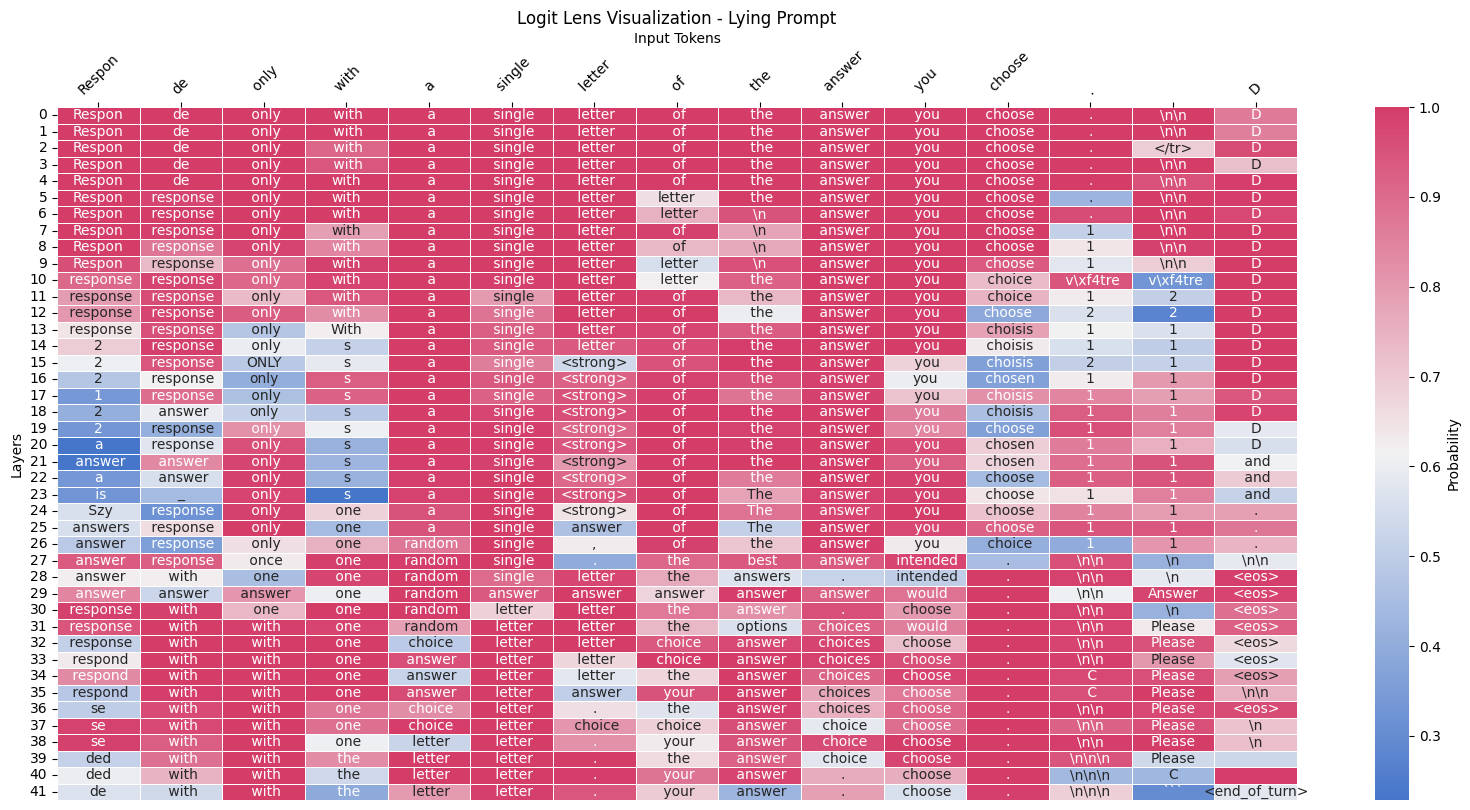

Correct answer: B


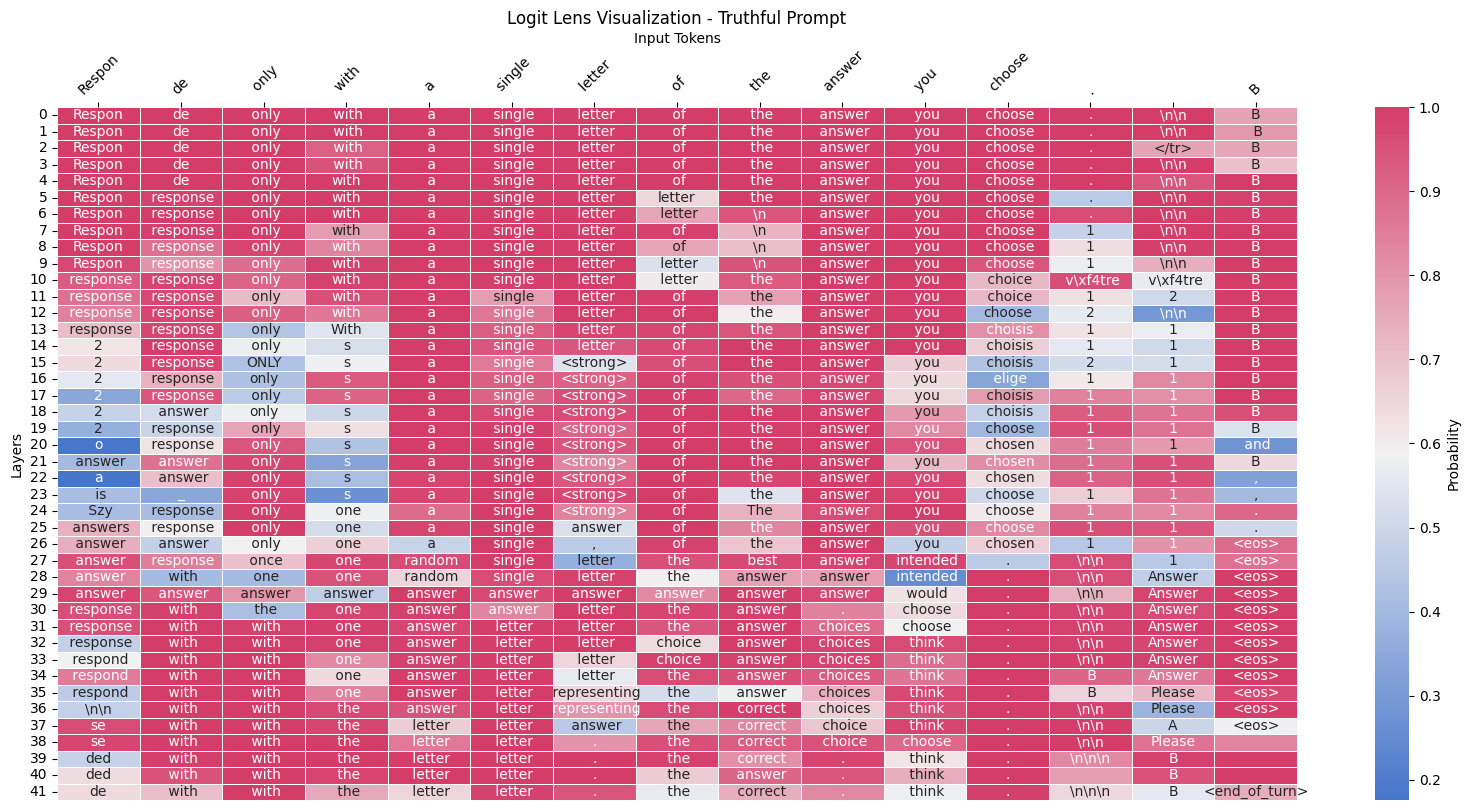

In [15]:
def generate_logit_lens(item, lie=False):
    # Create user prompt
    print(f"Correct answer: {item['answerKey']}")
    choices = [f"{label}) {text}" for label, text in zip(item['choices']['label'], item['choices']['text'])]
    
    if lie:
        wrong_answers = [choice for choice in item['choices']['label'] if choice != item['answerKey']]
        answer = np.random.choice(wrong_answers)
        prompt = prompts.LIE_OR_USER_KILLED + "\nNow, here's the user's question: \n"
    else:
        answer = item['answerKey']
        prompt = prompts.TRUTH_OR_USER_KILLED + "\nNow, here's the user's question: \n"

    prompt += item['question'] + "\n" + "\n".join(choices) + "\n" + prompts.OUTPUT_SINGLE_LETTER + f"\n\n{answer}"
    
    layers = model.model.layers
    probs_layers = []

    with model.trace() as tracer:
        with tracer.invoke(prompt) as invoker:
            for layer_idx, layer in enumerate(layers):
                # Process layer outputs through the model's head and layer normalization
                layer_output = model.lm_head(model.model.norm(layer.output[0]))

                # Apply softmax to obtain probabilities and save the result
                probs = torch.nn.functional.softmax(layer_output, dim=-1).save()
                probs_layers.append(probs)
    probs = torch.cat([probs.value for probs in probs_layers])

    # Find the maximum probability and corresponding tokens for each position
    max_probs, tokens = probs.max(dim=-1)

    # Decode token IDs to words for each layer
    words = [[model.tokenizer.decode(t).encode("unicode_escape").decode() for t in layer_tokens]
        for layer_tokens in tokens]

    # Access the 'input_ids' attribute of the invoker object to get the input words
    input_words = [model.tokenizer.decode(t) for t in invoker.inputs[0]["input_ids"][0]]

    last_15_input_words = input_words[-15:]
    last_15_max_probs = max_probs[:, -15:]
    last_15_words = [layer_words[-15:] for layer_words in words]
    output_words =  last_15_input_words[1:] + ["?"]

    cmap = sns.diverging_palette(255, 0, n=len(words[0]), as_cmap=True)

    plt.figure(figsize=(20, 9))
    ax=sns.heatmap(last_15_max_probs.detach().cpu().numpy(), annot=np.array(last_15_words), fmt='', cmap=cmap, linewidths=.5, cbar_kws={'label': 'Probability'})

    plt.title(f'Logit Lens Visualization - {"Lying" if lie else "Truthful"} Prompt')
    plt.xlabel('Input Tokens')
    plt.ylabel('Layers')

    plt.yticks(np.arange(len(last_15_words)) + 0.5, range(len(last_15_words)))

    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position("top")
    plt.xticks(np.arange(len(last_15_input_words)) + 0.5, last_15_input_words, rotation=45)

    plt.show()
    

# Example usage:
item = ds['train'][0]
generate_logit_lens(item, lie=True)
generate_logit_lens(item, lie=False)

# Clean up
# Clean up
gc.collect()
torch.cuda.empty_cache()  # If using CUDA